In [1]:
# This lets us refresh changes from other .py files without having to restart the notebook
%load_ext autoreload 
%autoreload 2

# Do some basic testing with existing implementations to see if everything works as expected

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import non_negative_factorization
from scipy.sparse.linalg import eigs
from scipy.linalg import dft
from scipy.io import wavfile
from scipy.signal import stft, istft, check_NOLA # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.stft.html
import matplotlib.pyplot as plt
from dataReader import SAMPLE_PATH
from utils import *

from dimensionalityReduction import getPCA, getICA, getNMF, decomposeAudio, decomposeAudioSlow, decomposeAudioSKLearn

In [3]:
def frameData(data, W, H, L):
    framedData = np.zeros((W, L//H))
    for frameIdx, frameRange in enumerate(range(0, L-W, H)):
        framedData[:, frameIdx] = data[frameRange:frameRange+W]

    return framedData

def getMagnitudeSpectrogram(W=1024, H=256, PRE_PADDING=0, filename='vl1.wav'):

    F = dft(W)
    PRE_PADDING = 0
    sampleRate, data = wavfile.read(filename)

    data = data.astype(np.float64)
    L = data.shape[0]

    extendLength = H - (L % H)
    data = np.pad(data, (H*PRE_PADDING, extendLength))
    L = data.shape[0]

    if len(data.shape) > 1:
        data = np.average(data, axis=1)

    framedData = frameData(data, W=W, H=H, L=L)
    framedData = framedData * np.hanning(W)[:, np.newaxis]

    spectrogram = np.dot(F, framedData)
    specMagnitude = np.abs(spectrogram)
    specLogged = np.log(specMagnitude+1e-6)
    
    # Cut spectrogram in half
    finalSpectrogram = specLogged[:W//2, :]
    # finalSpectrogram = specMagnitude[:W//2, :]

    return np.clip(finalSpectrogram, a_min=0, a_max=np.inf)

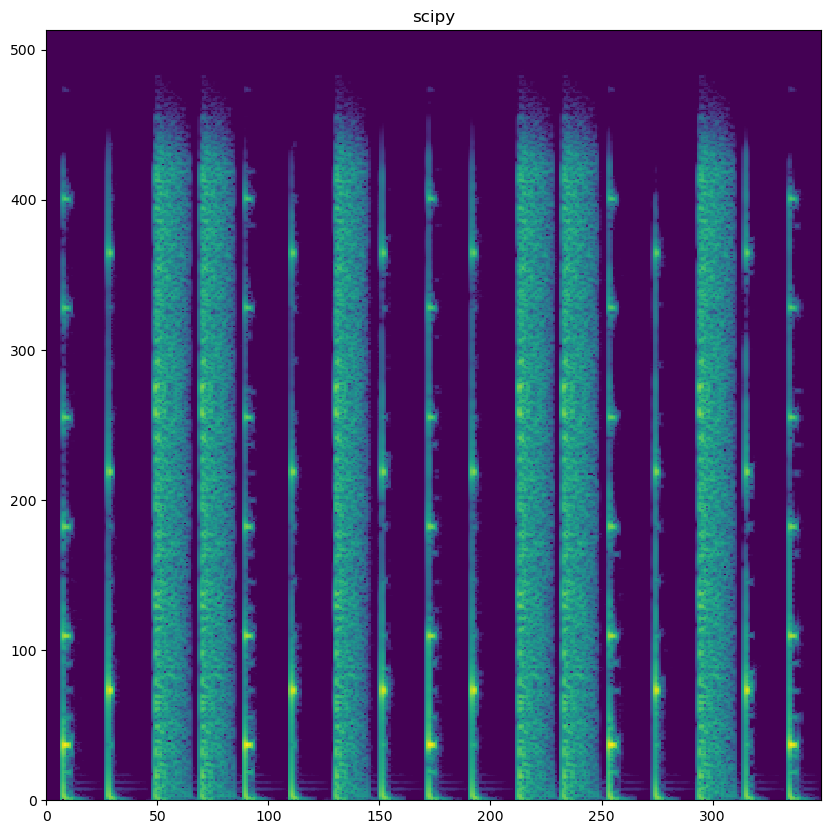

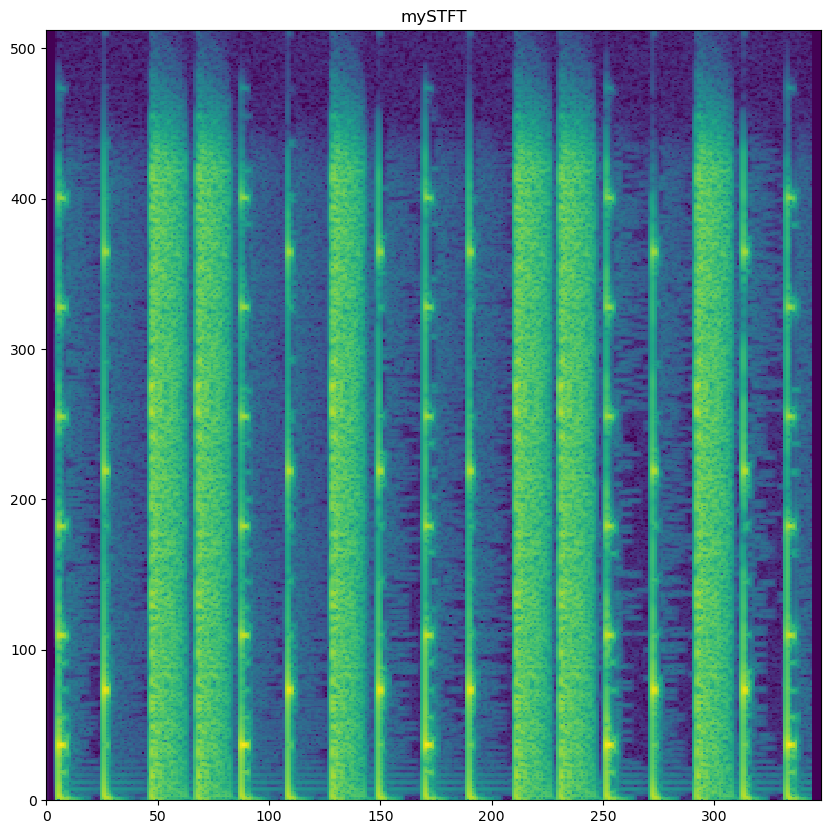

In [4]:

sample_rate, data = wavfile.read(SAMPLE_PATH)


mySTFT = getMagnitudeSpectrogram(filename=SAMPLE_PATH)

# stft returns a tuple of (sample frequencies, segment times, the STFT itself)
scipySTFT = stft(data, fs=sample_rate, window='hann', nperseg=1024, noverlap=3*1024//4)

# convertedScipySTFT = np.abs(scipySTFT[-1])
# convertedScipySTFT = np.log(np.abs(scipySTFT[-1]))
convertedScipySTFT = np.clip(np.log(np.abs(scipySTFT[-1])), a_min=0, a_max=np.inf)

plt.figure(figsize=(10, 10))
plt.pcolormesh(convertedScipySTFT), plt.title('scipy')
plt.show()

plt.figure(figsize=(10, 10))
plt.pcolormesh(mySTFT), plt.title('mySTFT')
plt.show()

## Try doing dimensionality reduction with PCA, ICA, and NMF

Break on iteration 7
Break on iteration 457


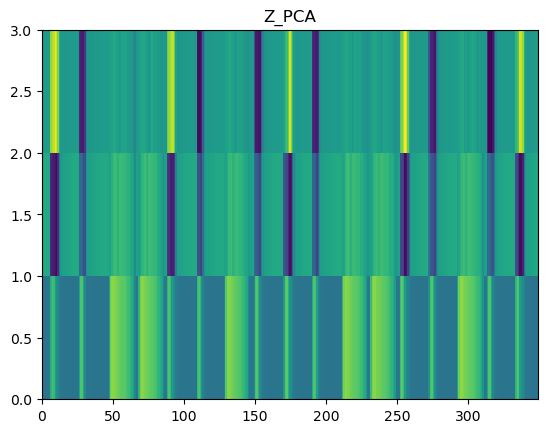

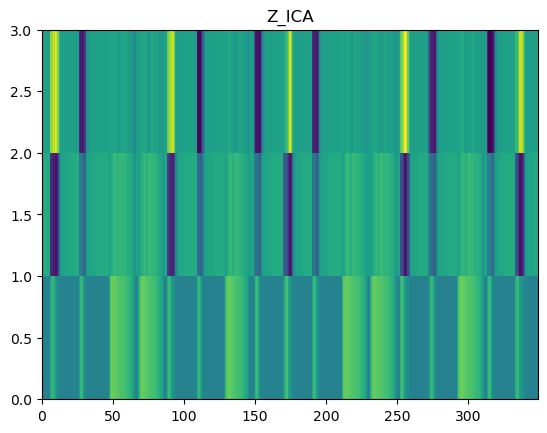

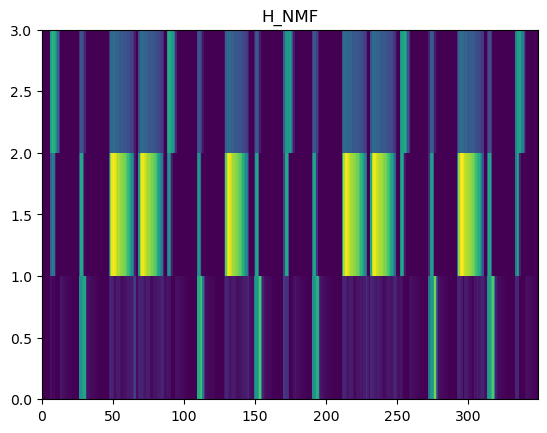

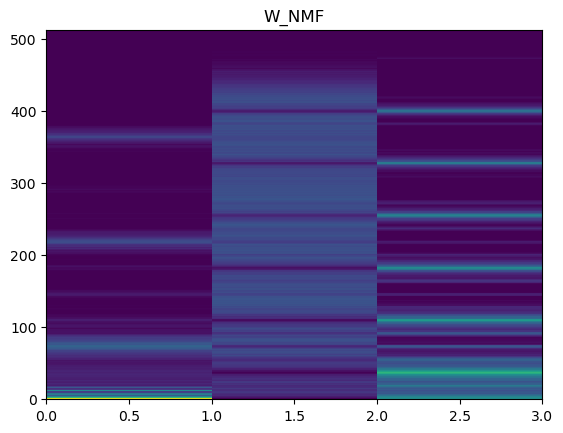

In [5]:
W_PCA, Z_PCA, xMean, xStd = getPCA(convertedScipySTFT, dims=3)
W_ICA, Z_ICA = getICA(Z_PCA)
W_NMF, H_NMF = getNMF(convertedScipySTFT, R=3, iterations=2000)

plt.pcolormesh(Z_PCA), plt.title("Z_PCA")
plt.show()

plt.pcolormesh(Z_ICA), plt.title("Z_ICA")
plt.show()

plt.pcolormesh(H_NMF), plt.title("H_NMF")
plt.show()

plt.pcolormesh(W_NMF), plt.title("W_NMF")
plt.show()

## Compare to sklearn implementations

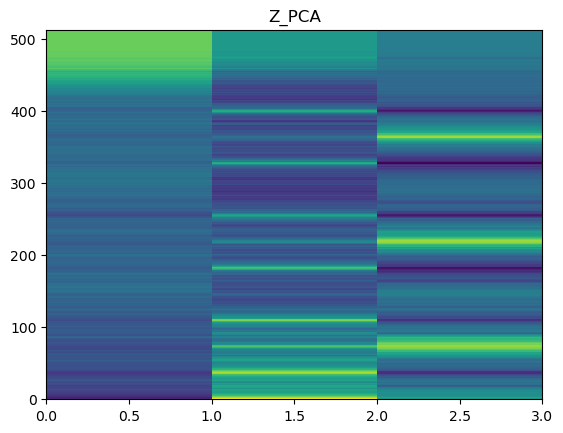

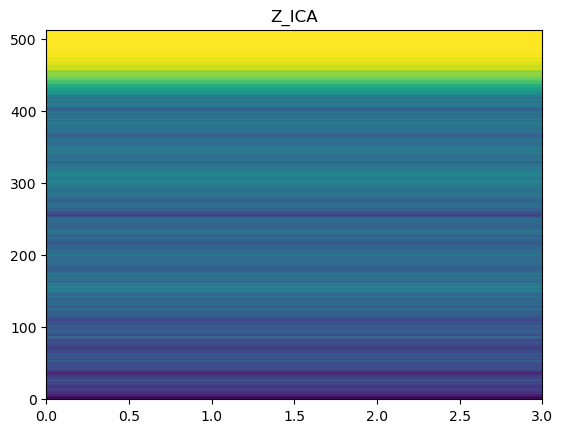

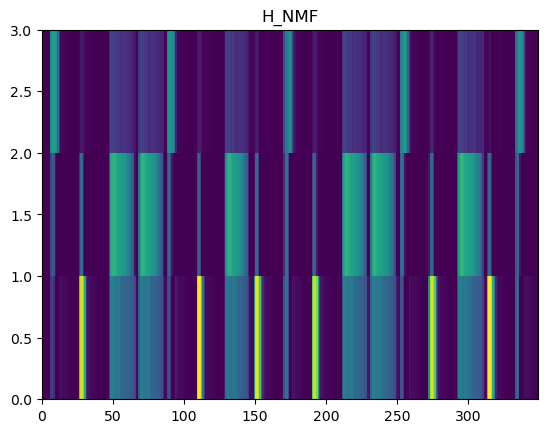

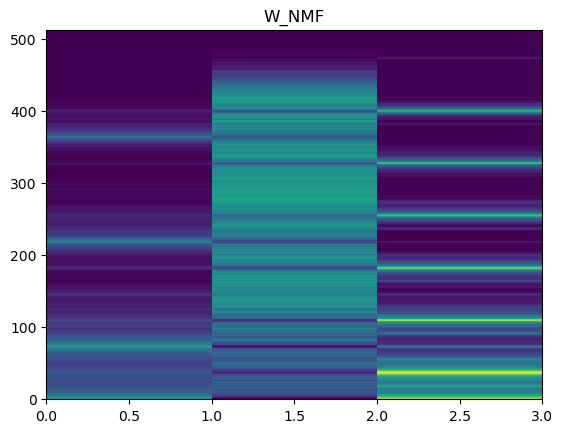

In [6]:
from sklearn.decomposition import PCA, FastICA, NMF

pca = PCA(n_components=3, whiten=True)
Z_PCA = pca.fit_transform(convertedScipySTFT)
W_PCA = pca.components_

ica = FastICA(n_components=3)
Z_ICA = ica.fit_transform(Z_PCA)
W_ICA = ica.components_

nmf = NMF(n_components=3, max_iter=400)
W_NMF = nmf.fit_transform(convertedScipySTFT)
H_NMF = nmf.components_


plt.pcolormesh(Z_PCA), plt.title("Z_PCA")
plt.show()

plt.pcolormesh(Z_ICA), plt.title("Z_ICA")
plt.show()

plt.pcolormesh(H_NMF), plt.title("H_NMF")
plt.show()

plt.pcolormesh(W_NMF), plt.title("W_NMF")
plt.show()

### Decompose audio from sample sounds

Break on iteration 75


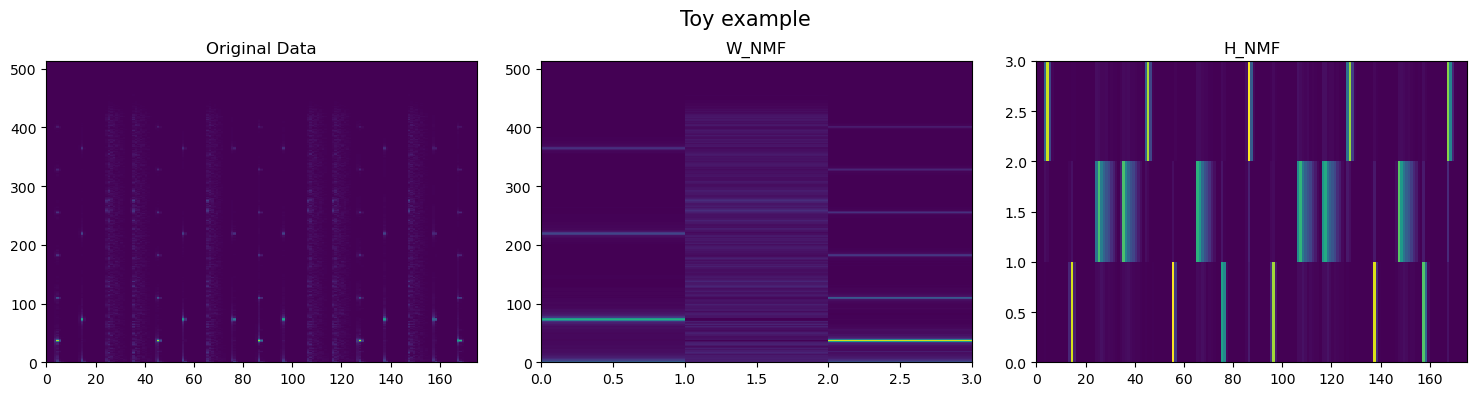

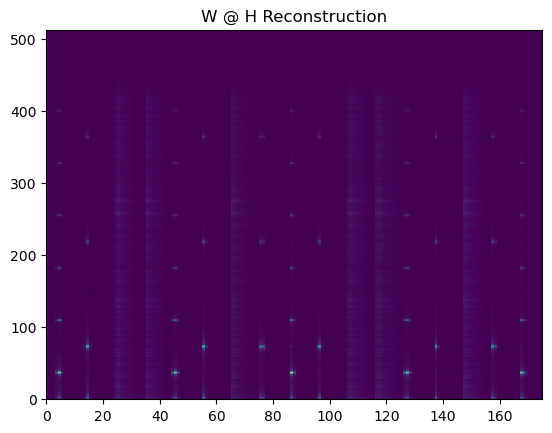

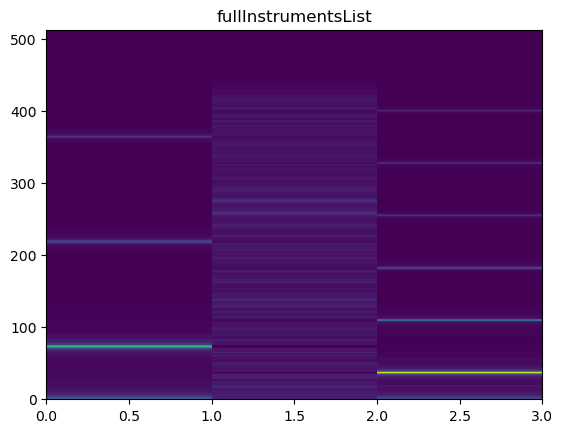

Finished after 399 iterations


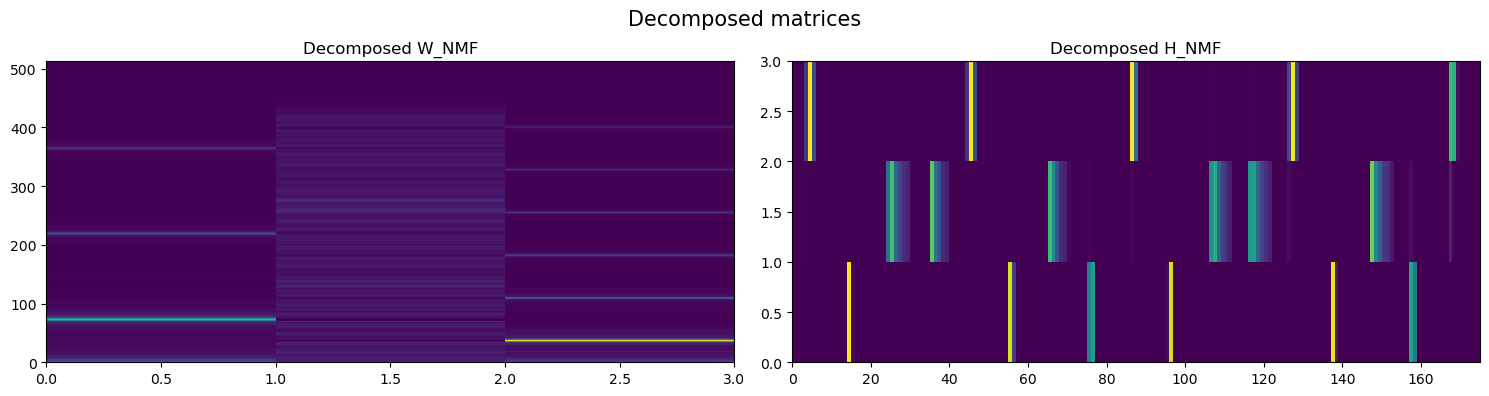

Min/Max (-0.09203631557188229+0.03502896678445076j) (0.10555879825917248+0.01994728679966166j)
Min/Max (-0.012946280508372885-0.002008654222988436j) (0.013869217102675847+0.0001584259748562101j)
Min/Max (-0.1230101342670133-0.09054497666044815j) (0.13700561266597983+0.09019030590573848j)


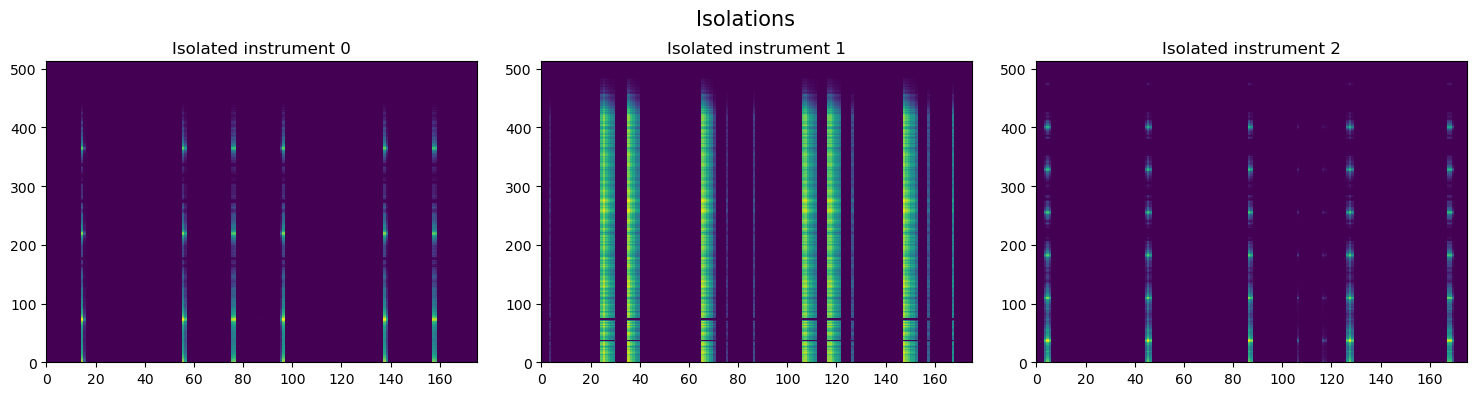

minSpec: (-0.12003528054708239-0.08835525414494626j) maxSpec: (0.13369193271905253+0.08800892222173051j)
minRaw: -25159 maxRaw: 32767


In [10]:
sample_rate, data = wavfile.read(SAMPLE_PATH) # data is int16. Do I need to read and write in the same format?

NPERSEG = 1024
NOVERLAP = NPERSEG // 2

assert check_NOLA(window='hann', nperseg=NPERSEG, noverlap=NOVERLAP)

data = normalizeWAV(data)

# stft returns a tuple of (sample frequencies, segment times, the STFT itself)
scipySTFT = stft(data, fs=sample_rate, window='hann', nperseg=NPERSEG, noverlap=NOVERLAP)
PHASE = np.angle(scipySTFT[-1])

# convertedScipySTFT = np.abs(scipySTFT[-1])
# convertedScipySTFT = np.log(np.abs(scipySTFT[-1]))
convertedScipySTFT = np.clip(np.abs(scipySTFT[-1]), a_min=0, a_max=np.inf) # convertedScipySTFT is float32


cmap = None

# Get instruments by using plain NMF to isolate the components
R = 3
W_NMF, H_NMF = getNMF(convertedScipySTFT, R=R, iterations=1000, optimizationMethod='KL')

fig, axes = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 3 columns
axes[0].pcolormesh(convertedScipySTFT, cmap=cmap), axes[0].set_title('Original Data')
axes[1].pcolormesh(W_NMF, cmap=cmap), axes[1].set_title('W_NMF')
axes[2].pcolormesh(H_NMF, cmap=cmap), axes[2].set_title('H_NMF')
plt.tight_layout()
fig.suptitle('Toy example', fontsize=15), plt.subplots_adjust(top=0.85)
plt.show()

plt.pcolormesh(W_NMF @ H_NMF, cmap=cmap), plt.title("W @ H Reconstruction"), plt.show()

# Repeat existing basis vectors multiple times. Noise is added later to make model more robust
instrumentsList = [np.tile(np.expand_dims(W_NMF[:, i], -1), (1, np.random.randint(low=1, high=2))) for i in range(R)]
countsList = [x.shape[-1] for x in instrumentsList]

fullInstrumentsList = np.concatenate(instrumentsList, axis=1)
# Add some noise for generalization
fullInstrumentsList += np.random.rand(*fullInstrumentsList.shape)*0

plt.pcolormesh(fullInstrumentsList, cmap=cmap), plt.title('fullInstrumentsList'), plt.show()



W_NMF, activations = decomposeAudio(X=convertedScipySTFT, W=fullInstrumentsList, H=None, iterations=400, useRegularization=True, regularization=1e-4) # fullInstrumentsList is still float32

fig, axes = plt.subplots(1, 2, figsize=(15, 4))  # 1 row, 3 columns
axes[0].pcolormesh(W_NMF, cmap=cmap), axes[0].set_title('Decomposed W_NMF')
axes[1].pcolormesh(activations, cmap=cmap), axes[1].set_title('Decomposed H_NMF')
plt.tight_layout()
fig.suptitle('Decomposed matrices', fontsize=15), plt.subplots_adjust(top=0.85)
plt.show()

isolations = []
currentBase = 0

for i, count in enumerate(countsList):
    
    currentActivations = activations[currentBase:currentBase+count, :] # float32
    currentBases = W_NMF[:, currentBase:currentBase+count] # float32
    # plt.pcolormesh(currentActivations), plt.title('currentActivations'), plt.show(), plt.pcolormesh(currentBases), plt.title('currentBases'), plt.show()
    
    # Re-introduce phase information. This is actually very important in the overall quality of the reconstruction, as there is an audible difference
    currentReconstruction = (currentBases @ currentActivations) * np.exp(1j * PHASE) # complex64

    print(f'Min/Max {np.min(currentReconstruction)} {np.max(currentReconstruction)}')
    isolations.append(currentReconstruction)
    currentBase += count
    

fig, axes = plt.subplots(1, R, figsize=(15, 4))  # 1 row, 3 columns
for i, isolation in enumerate(isolations):
    axes[i].pcolormesh(np.log(np.abs(isolation)+1e-4), cmap=cmap), axes[i].set_title(f'Isolated instrument {i}')
plt.tight_layout()
fig.suptitle('Isolations', fontsize=15), plt.subplots_adjust(top=0.85)
plt.show()


def normalizeWAV(arr):
    maxVal = np.max(np.abs(arr))

    normalized_arr = arr * (1.0 / maxVal)
    return normalized_arr

    
for idx, isolation in enumerate(isolations):
    t, x = istft(isolation, fs=sample_rate, window='hann', nperseg=NPERSEG, noverlap=NOVERLAP) # x is float32

    x = normalizeWAV(x) # x is still float32
    x = convertFloat32toInt16(x)
    wavfile.write(f'Instrument{idx}.wav', rate=sample_rate, data=x)
    
    
    
# Write the reconstruction from NMF to make sure it works
reconstruction = (W_NMF @ H_NMF) * np.exp(1j * PHASE)
print(f'minSpec: {np.min(reconstruction)} maxSpec: {np.max(reconstruction)}')
t, x = istft(reconstruction, fs=sample_rate, window='hann', nperseg=NPERSEG, noverlap=NOVERLAP)

x = normalizeWAV(x)
x = convertFloat32toInt16(x)
print(f'minRaw: {np.min(x)} maxRaw: {np.max(x)}')

wavfile.write(f'decompositions\\originalReconstruction.wav', rate=sample_rate, data=x)
